In [917]:
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from sklearn.datasets import load_wine, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score

from lime.lime_tabular import LimeTabularExplainer

RANDOM_STATE = 0

In [918]:
wine = load_wine()
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

## Utils

In [919]:
def ascat(y_num):
    y_num = np.array(y_num)
    return np.vectorize(wine.target_names.__getitem__)(y_num.ravel()).reshape(y_num.shape)

CAT2NUM = {c: i for i, c in enumerate(wine.target_names)}

def asnum(y_cat):
    y_cat = np.array(y_cat)
    return np.vectorize(CAT2NUM.get)(y_cat.ravel()).reshape(y_cat.shape)

In [920]:
X = wine.data
y = ascat(wine.target)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))
split = np.array(['train'] * len(X_train) + ['test'] * len(X_test))

In [921]:
pca2 = PCA(n_components=2)
X_train2 = pca2.fit_transform(X_train)
X_test2 = pca2.transform(X_test)
X_pca2 = np.vstack((X_train2, X_test2))

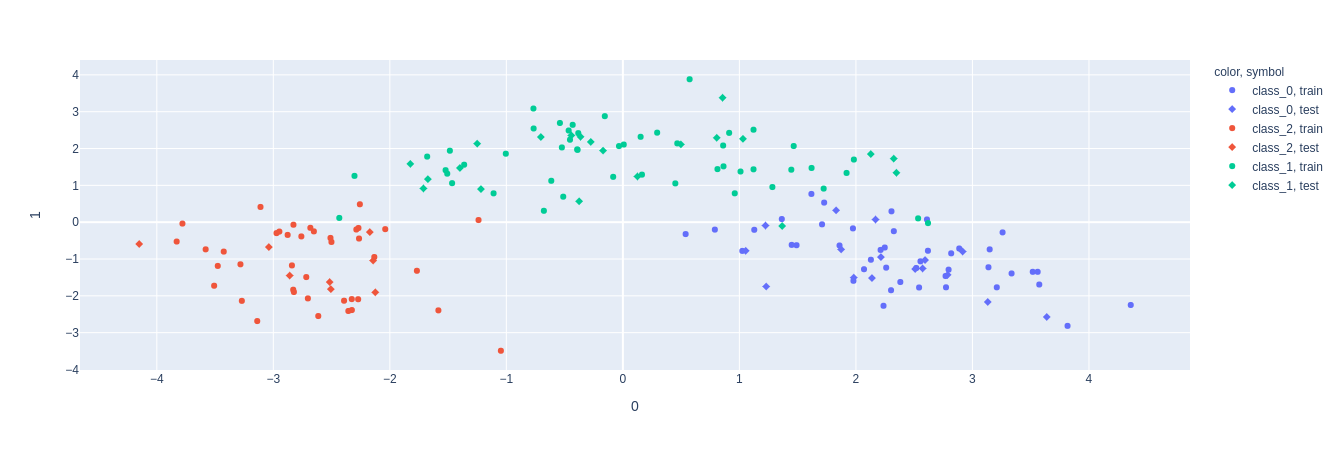

In [922]:
px.scatter(X_pca2, 0, 1, y, split)

In [923]:
pca3 = PCA(n_components=3)
X_train3 = pca3.fit_transform(X_train)
X_test3 = pca3.transform(X_test)
X_pca3 = np.vstack((X_train3, X_test3))

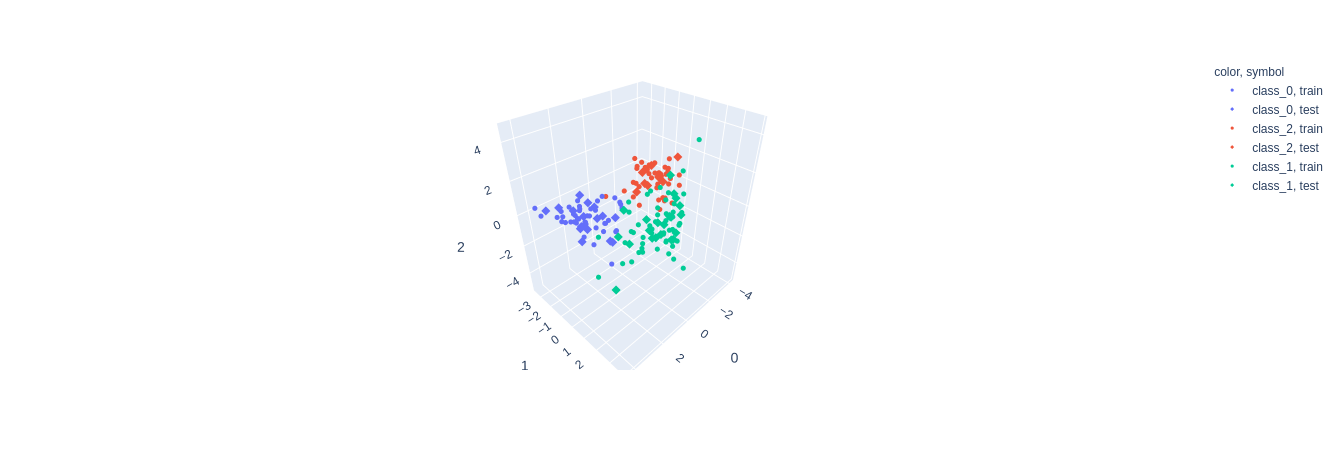

In [924]:
fig = px.scatter_3d(X_pca3, 0, 1, 2, y, split)
fig.update_traces(marker=dict(size=3))

In [925]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)
accuracy_score(y_test, svc.predict(X_test))

1.0

In [926]:
y_pred = svc.predict(X)
accuracy_score(y, svc.predict(X))

0.9943820224719101

In [927]:
padding = 1.25
num = 200

x0_min = X_pca2[:, 0].min() * padding
x0_max = X_pca2[:, 0].max() * padding
h0 = (x0_max - x0_min) / num

x1_min = X_pca2[:, 1].min() * padding
x1_max = X_pca2[:, 1].max() * padding
h1 = (x1_max - x1_min) / num

x0s = np.arange(x0_min, x0_max, h0)
x1s = np.arange(x1_min, x1_max, h1)

mesh_pca2 = np.meshgrid(x0s, x1s)
mesh_pca2 = np.array(mesh_pca2).reshape(2, num**2).T
mesh = pca2.inverse_transform(mesh_pca2)

In [928]:
mesh_pca2.shape

(40000, 2)

In [929]:
mesh.shape

(40000, 13)

In [930]:
y_mesh = svc.predict(mesh).reshape(num, num)

In [931]:
y_mesh.shape

(200, 200)

In [932]:
pca2.transform([X_test[5]])

array([[ 1.36750624, -0.10407461]])

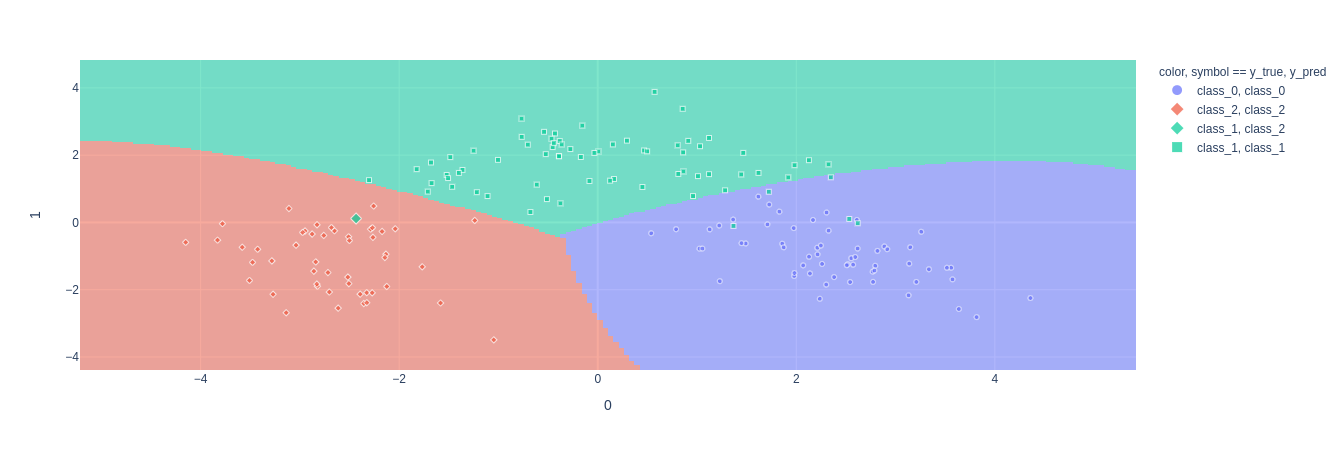

In [933]:
fig = px.scatter(
    X_pca2,
    x=0,
    y=1,
    color=y,
    symbol=y_pred,
    size=[1 if yt == yp else 3 for yt, yp in zip(y, y_pred)],
    size_max=6,
    hover_data={
        'index': range(len(X_pca2)),
    },
)
fig.add_trace(
    go.Heatmap(
        x=x0s,
        y=x1s,
        z=asnum(y_mesh),
        zmin=0,
        zmax=2,
        opacity=0.5,
        colorscale=[[0, '#636efa'], [1/3, '#636efa'], [1/3, '#00cc96'], [2/3, '#00cc96'], [2/3, '#EF553B'], [1, '#EF553B']],
        colorbar=dict(
            tickvals=[1/3, 1, 5/3],
            ticktext=[0, 1, 2],
        ),
        showscale=False,
        hoverinfo='skip',
    ),
)
fig.layout.legend.title = 'color, symbol == y_true, y_pred'
fig.show()

In [934]:
poi = X[65]
pca2.transform([poi])

array([[-1.23880696,  0.05842729]])

In [935]:
blob, *_ = make_blobs(
    n_samples=1000,
    n_features=X.shape[1],
    centers=[np.zeros_like(poi)],
    cluster_std=1,
#     random_state=RANDOM_STATE,
)
blob_scaler = StandardScaler(with_mean=False).fit(X_train)
blob = blob * blob_scaler.scale_ + poi
blob = np.vstack([poi, blob])
# print(blob.std(axis=0))
# print(X_train.std(axis=0))
# print(blob.mean(axis=0))
# print(poi)
# pca2.transform(blob)

In [936]:
def mahalanobis(a, b, std):
    d = np.atleast_2d((b - poi) / std)
    return np.sqrt(np.sum(d**2))

def kernel(d):
    return np.exp(-d**2)

In [937]:
blob_weights = [kernel(mahalanobis(poi, b, blob_scaler.scale_)) for b in blob]

In [938]:
blob_pca2 = pca2.transform(blob)
blob_pca2.shape

(1001, 2)

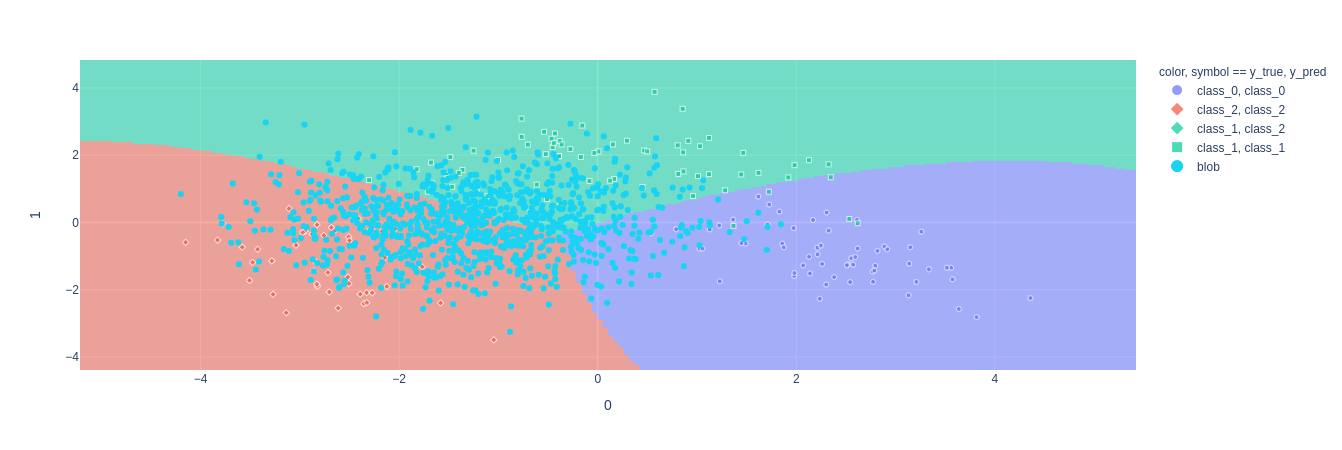

In [939]:
fig.add_trace(go.Scatter(x=blob_pca2[:, 0], y=blob_pca2[:, 1], name='blob', mode='markers'))

In [940]:
blob_proba = svc.predict_proba(blob)

In [1087]:
explanation = ElasticNet(0.001, 0.1).fit(blob - poi, blob_proba, sample_weight=blob_weights)

/home/luknw/.conda/envs/um-lime/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning:

Pass l1_ratio=0.1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error



In [1088]:
# l1 = 0.05
# l2 = 1
# explanation = ElasticNet(alpha=l1+l2, l1_ratio=l1/((l1+l2) if l1+l2 != 0 else 1)).fit(blob - poi, blob_proba, sample_weight=blob_weights)

In [1089]:
explanation.predict([poi])

array([[-0.02769856,  0.34707858,  0.68223462]])

In [1090]:
svc.predict_proba([poi])

array([[0.01503913, 0.27145931, 0.71350155]])

In [1100]:
explanation.intercept_

array([0.02141695, 0.3455722 , 0.63311629])

In [1092]:
explanation.coef_

array([[ 1.05338265e-02,  8.46037060e-03,  1.72201523e-04,
        -1.42225505e-02,  0.00000000e+00,  1.51516945e-02,
         2.35080487e-02, -5.90774465e-03,  2.23421441e-03,
        -2.63105460e-03, -6.83882453e-04,  5.57683564e-03,
         1.57012934e-02],
       [-8.12051946e-02, -1.12734876e-01, -5.41536429e-02,
        -9.79228379e-02,  1.03813113e-01, -1.36905894e-03,
         1.24413786e-01, -1.74540569e-02,  4.98112274e-02,
        -1.72564476e-01,  1.35447529e-01,  8.37960664e-02,
         3.71657705e-02],
       [ 6.97275970e-02,  1.03292243e-01,  5.37202821e-02,
         1.13420750e-01, -1.04116007e-01, -1.27097111e-02,
        -1.49039721e-01,  2.42941221e-02, -5.28540121e-02,
         1.76107050e-01, -1.34758554e-01, -9.04455393e-02,
        -5.43564342e-02]])

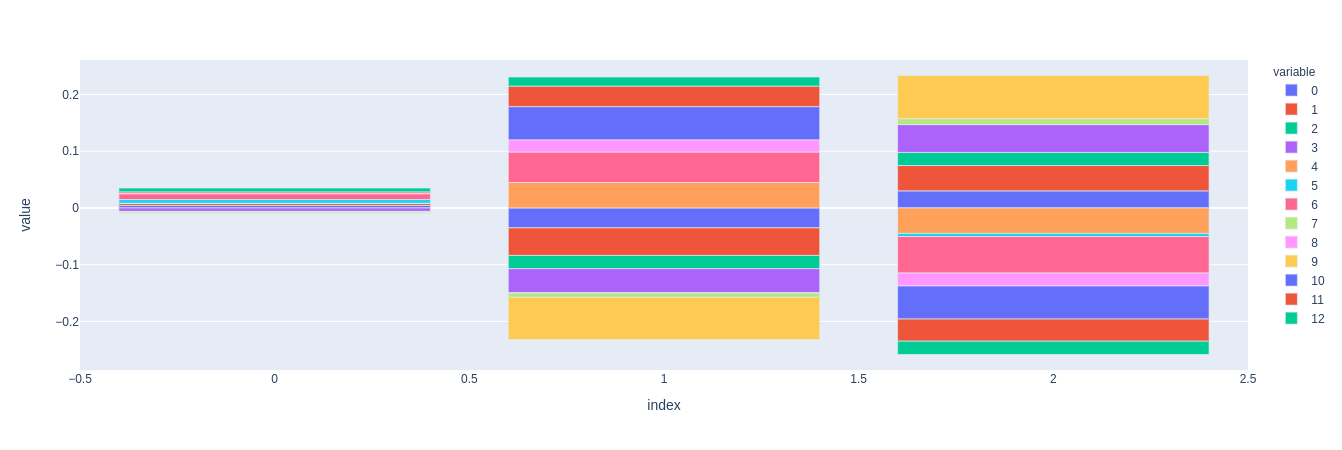

In [1093]:
px.bar(explanation.coef_ / np.abs(explanation.coef_).sum())

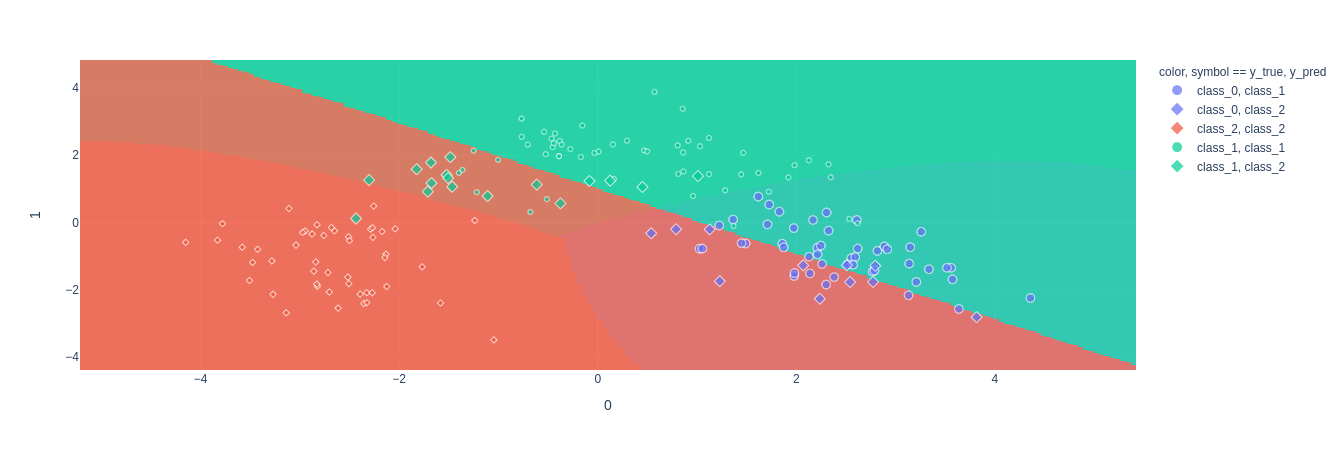

In [1010]:
fig = px.scatter(
    X_pca2,
    x=0,
    y=1,
    color=y,
    symbol=ascat(explanation.predict(X).argmax(-1)),
    size=[1 if yt == yp else 3 for yt, yp in zip(y, ascat(explanation.predict(X).argmax(-1)))],
    size_max=6,
    hover_data={
        'index': range(len(X_pca2)),
    },
)
fig.add_traces([
    go.Heatmap(
        x=x0s,
        y=x1s,
        z=explanation.predict(mesh).argmax(-1).reshape(num, num),
        opacity=0.8,
        colorscale=[[0, '#636efa'], [1/3, '#636efa'], [1/3, '#00cc96'], [2/3, '#00cc96'], [2/3, '#EF553B'], [1, '#EF553B']],
        colorbar=dict(
            tickvals=[1/3, 1, 5/3],
            ticktext=[0, 1, 2],
        ),
        showscale=False,
        hoverinfo='skip',
        zmin=0,
        zmax=2,
    ),
    go.Heatmap(
        x=x0s,
        y=x1s,
        z=asnum(y_mesh),
        zmin=0,
        zmax=2,
        opacity=0.1,
        colorscale=[[0, '#636efa'], [1/3, '#636efa'], [1/3, '#00cc96'], [2/3, '#00cc96'], [2/3, '#EF553B'], [1, '#EF553B']],
        colorbar=dict(
            tickvals=[1/3, 1, 5/3],
            ticktext=[0, 1, 2],
        ),
        showscale=False,
        hoverinfo='skip',
    ),
])
fig.layout.legend.title = 'color, symbol == y_true, y_pred'
fig.show()

In [972]:
pca2.transform([X[65]])

array([[-1.23880696,  0.05842729]])

In [973]:
xpl = LimeTabularExplainer(X_train, discretize_continuous=False, sample_around_instance=True)
ntn = xpl.explain_instance(X[65], svc.predict_proba)

In [1102]:
ntn.intercept

{1: 0.6418794730616884}